In [1]:
%pylab inline
import scipy.stats

from sigvisa.infer.correlations.event_proposal import correlation_location_proposal, generate_historical_db
#import seaborn as sns
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference


Populating the interactive namespace from numpy and matplotlib


In [2]:
#from sigvisa.experiments.aftershock_region import evids, stas
import cPickle as pickle
from sigvisa.source.event import get_event

stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']

doublet = 5334939

#evids = [5334501, 5334726, 5335822, 5349536, 
#         5336237, 5335424, 5349441, 
#         5336889, 5336015]
evids = [doublet,]

rs = EventRunSpec(evids=evids, stas=stas, runids=(1,), disable_conflict_checking=True)
ms = ModelSpec(template_model_type="param", wiggle_family="iid", 
               max_hz=10.0, inference_preset="openworld", raw_signals=True)
sg = rs.build_sg(ms)

doublet_ev = get_event(evid=doublet)
sg.event_start_time = doublet_ev.time-150
sg.event_end_time = doublet_ev.time + 150

with open("corr.sg", 'wb') as f:
    pickle.dump(sg, f)
    
#with open("corr.sg", 'rb') as f:
#    sg = pickle.load(f)

In [3]:
stas = ['AS12', 'MK31', 'CM16', 'FITZ']

#nearby_evids = [5334501, 5334726, 5335822, 5349536, 5336237, 5335424, 5349441]
#irrelevant_evids = [5321052, 5301042, 5301165, 5301302, 5301783, 5311139 ]
#hevids = nearby_evids + irrelevant_evids
hevids = [5335822, 5349536]
history = generate_historical_db(stas, hevids, bands=["freq_0.8_4.5"], chans=["auto"],len_s=10.0)

1240241574.35 1240242005.69
1240241946.92 1240242164.7
1240241739.3 1240241949.3
1240241505.56 1240241715.56
1240249325.45 1240249535.45
1240249697.42 1240249907.42
no arrivals found for evid 5349536 at station CM16
no arrivals found for evid 5349536 at station FITZ


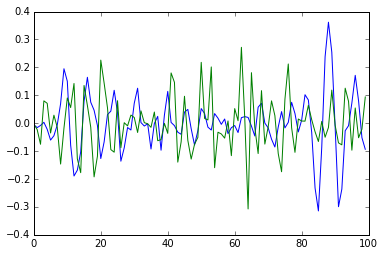

In [4]:
c1 = history[0][1][("MK31", "BHZ", "freq_0.8_4.5")]
c2 = history[1][1][("MK31", "BHZ", "freq_0.8_4.5")]

plot(c1)
plot(c2)


In [11]:
pev, evlp, (proposal_weights, proposal_otime_posteriors) = correlation_location_proposal(sg, history=history, 
                                                                                         temper=1, 
                                                                                         stas=["CM16", "MK31", "FITZ", "AS12"])

In [12]:
print proposal_weights
print doublet_ev
print pev


[ 0.97619048  0.02380952]
evid 5334939.0, loc 129.76 E 4.09 S, depth 0.0km, time 1240245385.7, mb 4.2, natural source
evid None, loc 129.77 E 4.14 S, depth 7.1km, time 1240245386.3, mb 4.0, natural source


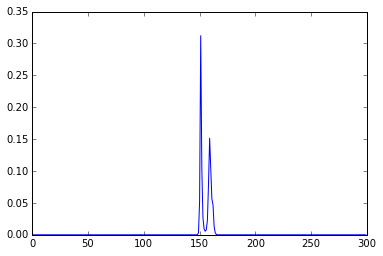

In [13]:
plot(proposal_otime_posteriors[0])

In [28]:
from sigvisa.signals.io import load_event_station_chan
sta="MK31"
chan="BHZ"
band="freq_0.8_4.5"
srate=10.0
evid1 = 5334939
evid2 = 5335822
evid3 = 5349536

w1 =  load_event_station_chan(evid1, sta, chan, evtype="leb")
w1 = w1.filter("%s;hz_%f" % (band, srate))

w2 =  load_event_station_chan(evid2, sta, chan, evtype="leb")
w2 = w2.filter("%s;hz_%f" % (band, srate))

w3 =  load_event_station_chan(evid3, sta, chan, evtype="leb")
w3 = w3.filter("%s;hz_%f" % (band, srate))

1240246021.58 1240246231.58
1240241946.92 1240242164.7
1240249697.42 1240249907.42


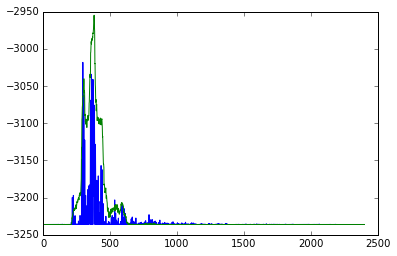

In [43]:
from sigvisa.infer.correlations.proposal_signal_likelihood import likelihood_windowed, iidbaseline
sdata = w1.data
sigma2_B = np.std(sdata)**2

iidb, _ = iidbaseline(sdata, 100, sigma2_B)

taus = np.linspace(0, 1, 50)
mls1= []
mls2 = []
#for tau in taus:
tau = 0.90
if True:
    wls1 = likelihood_windowed(sdata, tau*c1.data, 1-tau**2*k1, sigma2_B)
    lls1 = wls1 + iidb
    wls2 = likelihood_windowed(sdata, tau*c2.data, 1-tau**2*k2, sigma2_B)
    lls2 = wls2 + iidb
    plot(lls1)
    plot(lls2)
    #mls1.append(np.max(lls1))
    #mls2.append(np.max(lls2))
#plot(taus, mls1)
#plot(taus, mls2)


0.772066505807 296


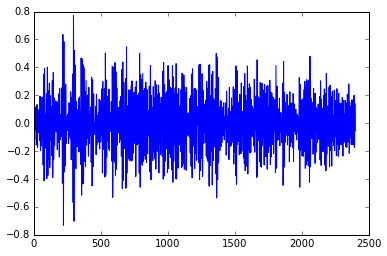

In [31]:
from sigvisa.signals.xc import my_xc
xxc = my_xc(c1.data, sdata)
plot(xxc)
print np.max(xxc), np.argmax(xxc)

In [45]:
print sigma2_B

1.27656228965
